<a href="https://colab.research.google.com/github/rhozon/Banca-FAE/blob/master/AgenteRLtreinado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Baixando ZC=F...


/usr/local/lib/python3.11/dist-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Baixando ZO=F...


/usr/local/lib/python3.11/dist-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Baixando KE=F...


/usr/local/lib/python3.11/dist-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Baixando GF=F...


/usr/local/lib/python3.11/dist-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Baixando ZS=F...


/usr/local/lib/python3.11/dist-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Baixando ZM=F...


/usr/local/lib/python3.11/dist-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Baixando ZL=F...


/usr/local/lib/python3.11/dist-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.32e+03 |
|    ep_rew_mean     | 1.9e+04  |
| time/              |          |
|    fps             | 267      |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 1.32e+03      |
|    ep_rew_mean          | 9.74e+03      |
| time/                   |               |
|    fps                  | 218           |
|    iterations           | 2             |
|    time_elapsed         | 18            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00018858249 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -7.69   

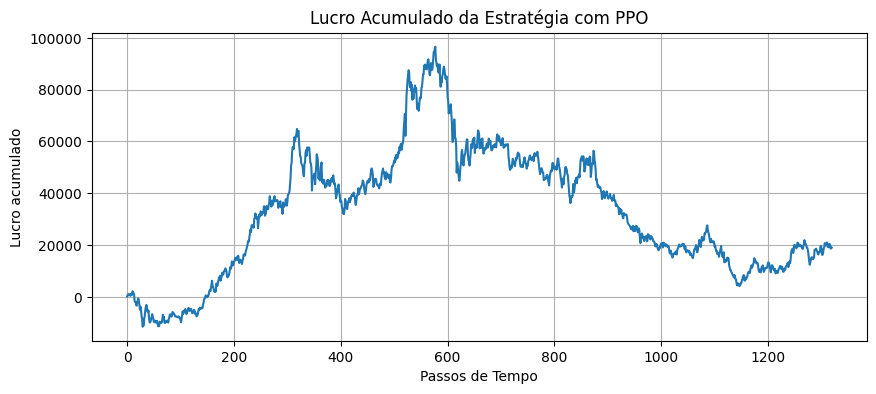

In [3]:
# 🧱 Instalação de dependências
!pip install --quiet yahooquery stable-baselines3 gymnasium shimmy

# 📚 Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from yahooquery import Ticker
import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import FlattenObservation
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor

# ⚙️ Configurações
TICKERS = ["ZC=F", "ZO=F", "KE=F", "GF=F", "ZS=F", "ZM=F", "ZL=F"]
START = "2020-01-01"
END = pd.Timestamp.today().strftime('%Y-%m-%d')
INITIAL_BALANCE = 100_000
TRANSACTION_COST = 0.001
WINDOW_SIZE = 20
SEED = 42

# 🎯 Função para baixar os dados
def get_price_data(tickers):
    data = {}
    for ticker in tickers:
        print(f"Baixando {ticker}...")
        tq = Ticker(ticker)
        hist = tq.history(start=START, end=END).reset_index()
        hist = hist[hist['symbol'] == ticker][['date', 'adjclose']]
        hist.rename(columns={'adjclose': ticker}, inplace=True)
        hist.set_index('date', inplace=True)
        data[ticker] = hist
    return pd.concat(data.values(), axis=1)

# ⏬ Baixar preços e calcular log-retornos
price_df = get_price_data(TICKERS)
price_df.dropna(inplace=True)
log_returns = np.log(price_df / price_df.shift(1)).dropna()

# 🏗️ Ambiente personalizado
class PortfolioEnv(gym.Env):
    def __init__(self, returns, window_size=20, initial_balance=100000, transaction_cost=0.001):
        super().__init__()
        self.returns = returns
        self.assets = returns.columns
        self.n_assets = len(self.assets)
        self.window_size = window_size
        self.initial_balance = initial_balance
        self.transaction_cost = transaction_cost
        self.action_space = spaces.MultiDiscrete([3] * self.n_assets)  # 0=Sell, 1=Hold, 2=Buy
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(window_size, self.n_assets), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.positions = np.zeros(self.n_assets)
        return self._get_obs(), {}

    def _get_obs(self):
        return self.returns.iloc[self.current_step - self.window_size:self.current_step].values.astype(np.float32)

    def step(self, actions):
        prev_value = self._get_portfolio_value()
        current_returns = self.returns.iloc[self.current_step].values
        for i, action in enumerate(actions):
            if action == 0:  # Sell
                self.balance += self.positions[i]
                self.positions[i] = 0
            elif action == 2:  # Buy
                allocation = (self.balance / self.n_assets) * (1 - self.transaction_cost)
                self.positions[i] += allocation
                self.balance -= allocation
        self.current_step += 1
        new_value = self._get_portfolio_value()
        reward = new_value - prev_value
        done = self.current_step >= len(self.returns)
        return self._get_obs(), reward, done, False, {}

    def _get_portfolio_value(self):
        if self.current_step <= self.window_size:
            return self.balance
        prices = np.cumprod(1 + self.returns.iloc[self.window_size:self.current_step].values, axis=0)[-1]
        values = self.positions * prices
        return self.balance + np.sum(values)

# 🧪 Inicialização e flatten
raw_env = PortfolioEnv(log_returns, window_size=WINDOW_SIZE, initial_balance=INITIAL_BALANCE)
env = Monitor(FlattenObservation(raw_env))

# 🏋️ Treinamento com PPO
model = PPO("MlpPolicy", env, verbose=1, seed=SEED)
model.learn(total_timesteps=50_000)

# 📊 Avaliação
obs, _ = env.reset()
rewards = []
done = False
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = env.step(action)
    rewards.append(reward)

# 📈 Gráfico do lucro acumulado
cumulative_rewards = np.cumsum(rewards)
plt.figure(figsize=(10, 4))
plt.plot(cumulative_rewards)
plt.title("Lucro Acumulado da Estratégia com PPO")
plt.xlabel("Passos de Tempo")
plt.ylabel("Lucro acumulado")
plt.grid(True)
plt.show()


In [5]:

# 📥 Entrada manual de um cenário simulado (últimos WINDOW_SIZE dias + novo dia)
# Exemplo: cenário hipotético para os 7 ativos
# Lembarndo que
# TICKERS = ["ZC=F", "ZO=F", "KE=F", "GF=F", "ZS=F", "ZM=F", "ZL=F"]
cen_otimista = np.array([
    [ 0.01,  0.015,  0.012,  0.008,  0.02,  0.017,  0.01]  # Retornos simulados do "próximo" dia
])

# Pega os últimos WINDOW_SIZE - 1 retornos reais
historico = log_returns.iloc[-(WINDOW_SIZE - 1):].values

# Concatena os dados reais + cenário simulado
estado_simulado = np.vstack([historico, cen_otimista]).astype(np.float32)

# Coloca no formato exigido pela rede (flatten se necessário)
obs_flat = estado_simulado.flatten().reshape(1, -1)

# Gera a ação recomendada pelo agente treinado
acao_recomendada, _ = model.predict(obs_flat, deterministic=True)

# 🎯 Resultado
print("Ações sugeridas pelo agente treinado:")
for ticker, acao in zip(TICKERS, acao_recomendada[0]):
    status = {0: "VENDER", 1: "ESPERAR", 2: "COMPRAR"}[acao]
    print(f"- {ticker}: {status}")



Ações sugeridas pelo agente treinado:
- ZC=F: COMPRAR
- ZO=F: VENDER
- KE=F: COMPRAR
- GF=F: COMPRAR
- ZS=F: COMPRAR
- ZM=F: ESPERAR
- ZL=F: COMPRAR
